# Measuring the Entropy of English Language

In the present notebook

In [223]:
import numpy             as np 
import matplotlib.pyplot as plt
import pandas            as pd
import glob
import re
from   nltk              import ngrams, FreqDist

In [16]:
##########################################################################
# Path where the books in TXT format are located
##########################################################################
path = 'Gutenberg/txt'

In [17]:
##########################################################################
# Getting file names (book titles)
##########################################################################
f_names = []
for file in glob.glob(path + "/*.txt"):
    f_names.append(file)

In [20]:
##########################################################################
# Let's print of to check
##########################################################################
print(f_names[0])

Gutenberg/txt\Abraham Lincoln___Lincoln Letters.txt


Let's first load "Robson Crusoe" by Daniel Defoe. But first we have to define soma auxiliary functions to pre-process the text file!

In [108]:
##########################################################################
# Define class bookwork, to read and prepare the text for us!
##########################################################################
class BookWorm():
    
    def __init__(self,):
        None

    ##########################################################################
    # This function you read the book file given its path
    ##########################################################################
    def read_book(self, path):
        with open(path, 'r') as file_object:
            book = file_object.read()
        return book

    ##########################################################################
    # This function receives the raw text and remove special characters
    ##########################################################################
    def remove_special(self, book):
        final = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in book.split("\n")]
        return final

    ##########################################################################
    # This function vectorizes the book , i.e. concatenates every sentence 
    # in a single list each sentence is separated by a space
    ##########################################################################
    def vectorize(self, text_no_special, remove_spaces = False):
        text = ''
        for sentence in text_no_special:
            text = text + ' ' + sentence
        text = re.sub(' +', ' ', text) # Removes double spaces
        if text[0] == ' ':
            return text[1:].lower() # Rerurn only in lowercase
        else:
            return text.lower() # Rerurn only in lowercase
    
    def remove_numbers(self, text_vectorized):
        res = ''.join([i for i in text_vectorized if not i.isdigit()]) 
        return res

##########################################################################
# Define class to compute N-grams and its statistics
##########################################################################

In [109]:
# Instatiate a BookWork object
bw = BookWorm()
# Reading "Robison Crusoe"
book     = bw.read_book('Gutenberg/txt/Daniel Defoe___The Life and Adventures of Robinson Crusoe (1808).txt')
# Removing special characters (Book with no special characters)
book_ns  = bw.remove_special(book)
# Vectorizing book
book_v   = bw.vectorize(book_ns)
# Remove numbers
raw_text = bw.remove_numbers(book_v)

Let's check the final result

In [112]:
book_v

'the life and adventures of robinson crusoe by daniel de foe london 18o8 illustration i had one labour to make me a canoe which at last i finished the life of de foe daniel de foe was descended from a respectable family in the county of northampton and born in london about the year 1663 his father james foe was a butcher in the parish of st giles s cripplegate and a protestant dissenter why the subject of this memoir prefixed the de to his family name cannot now be ascertained nor did he at any period of his life think it necessary to give his reasons to the public the political scribblers of the day however thought proper to remedy this lack of information and accused him of possessing so little of the amor patriae as to make the addition in order that he might not be taken for an englishman though this idea could have had no other foundation than the circumstance of his having in consequence of his zeal for king william attacked the prejudices of his countrymen in his true born engli

In [113]:
from nltk import ngrams, FreqDist


In [213]:
_1gram=ngrams(words, 3)

In [214]:
_1gram

<generator object ngrams at 0x00000275B34DB248>

In [215]:
fdist = FreqDist(_1gram)

In [216]:
fdist.keys()

dict_keys([('t', 'h', 'e'), ('h', 'e', 'l'), ('e', 'l', 'i'), ('l', 'i', 'f'), ('i', 'f', 'e'), ('f', 'e', 'a'), ('e', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'a'), ('d', 'a', 'd'), ('a', 'd', 'v'), ('d', 'v', 'e'), ('v', 'e', 'n'), ('e', 'n', 't'), ('n', 't', 'u'), ('t', 'u', 'r'), ('u', 'r', 'e'), ('r', 'e', 's'), ('e', 's', 'o'), ('s', 'o', 'f'), ('o', 'f', 'r'), ('f', 'r', 'o'), ('r', 'o', 'b'), ('o', 'b', 'i'), ('b', 'i', 'n'), ('i', 'n', 's'), ('n', 's', 'o'), ('s', 'o', 'n'), ('o', 'n', 'c'), ('n', 'c', 'r'), ('c', 'r', 'u'), ('r', 'u', 's'), ('u', 's', 'o'), ('s', 'o', 'e'), ('o', 'e', 'b'), ('e', 'b', 'y'), ('b', 'y', 'd'), ('y', 'd', 'a'), ('d', 'a', 'n'), ('a', 'n', 'i'), ('n', 'i', 'e'), ('i', 'e', 'l'), ('e', 'l', 'd'), ('l', 'd', 'e'), ('d', 'e', 'f'), ('e', 'f', 'o'), ('f', 'o', 'e'), ('o', 'e', 'l'), ('e', 'l', 'o'), ('l', 'o', 'n'), ('o', 'n', 'd'), ('n', 'd', 'o'), ('d', 'o', 'n'), ('o', 'n', 'o'), ('n', 'o', 'i'), ('o', 'i', 'l'), ('i', 'l', 'l'), ('l', 'l', 'u'), ('l

In [217]:
len(fdist)

6473

In [218]:
len(raw_text)

1180784

In [219]:
p = np.array(list(fdist.values())) / np.array(list(fdist.values())).sum()

In [220]:
p.sum()

1.0

In [221]:
from itertools import chain
chn = chain.from_iterable(fdist.values())

In [222]:
-np.sum(p*np.log2(p))

10.732865938345288

ValueError: shape mismatch: objects cannot be broadcast to a single shape

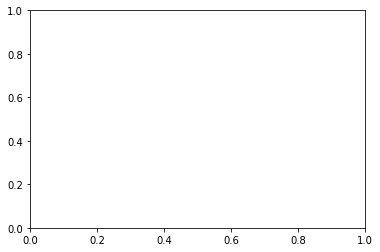

In [189]:
plt.bar(range(27),p * 100)
plt.xticks(range(27), fdist.keys(), rotation=90)

array([ 92671,  63408, 116122, 236137,  33784,  63549,  22311,  77478,
        63368,  43850,  10338,  26387,  51678,  54693,  75054,  14606,
        20620,  19591,  26129,   6408,  26430,  14602,    780,  18711,
         1091,    625,    363])

In [146]:
len(_1gram)

TypeError: object of type 'generator' has no len()

In [191]:
words = raw_text.replace(" ", "")

In [192]:
words

'thelifeandadventuresofrobinsoncrusoebydanieldefoelondonoillustrationihadonelabourtomakemeacanoewhichatlastifinishedthelifeofdefoedanieldefoewasdescendedfromarespectablefamilyinthecountyofnorthamptonandborninlondonabouttheyearhisfatherjamesfoewasabutcherintheparishofstgilesscripplegateandaprotestantdissenterwhythesubjectofthismemoirprefixedthedetohisfamilynamecannotnowbeascertainednordidheatanyperiodofhislifethinkitnecessarytogivehisreasonstothepublicthepoliticalscribblersofthedayhoweverthoughtpropertoremedythislackofinformationandaccusedhimofpossessingsolittleoftheamorpatriaeastomaketheadditioninorderthathemightnotbetakenforanenglishmanthoughthisideacouldhavehadnootherfoundationthanthecircumstanceofhishavinginconsequenceofhiszealforkingwilliamattackedtheprejudicesofhiscountrymeninhistruebornenglishmanafterreceivingagoodeducationatanacademyatnewingtonyoungdefoebeforehehadattainedhistwentyfirstyearcommencedhiscareerasanauthorbywritingapamphletagainstaveryprevailingsentimentinfavourofthe